## Import

In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import _LRScheduler

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import models
from torchsummary import summary
import torch.nn.functional as F
# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

print(os.environ.get('CUDA_VISIBLE_DEVICES'))

/home/MMI24limbyungwan/.conda/envs/byungwan_resn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
2


## Utils

In [2]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 클래스별 IoU를 계산하기 위한 함수
def calculate_iou_per_class(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    iou = intersection / union if union > 0 else 0
    return iou

## Dataset, Data Loader

출력이미지 크기 키우기->ex) resnet 2048->1024->512->256 conv 256->512->1024->2048

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        directory_path = "/mnt/nas27/Dataset/Samsung_DM"
        img_path = self.data.iloc[idx, 1]
        img_path = os.path.join(directory_path, img_path[2:])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask_path = os.path.join(directory_path, mask_path[2:])
        mask = cv2.imread(mask_path)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask[mask == 255] = 12 #배경을 픽셀값 12로 간주

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask
    
    # 이미지 전처리 클래스
class ImageTransform():
  """
  훈련, 검증 동작 다르게 설정
  이미지 크기 resize, 색상 표준화
  훈련시 RandomResizedCrop, RandomHorizontalFilp으로 데이터 확장
  """
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train' : transforms.Compose([
            #transforms.RandomResizedCrop(
            #    resize, scale = (0.5, 1.0)), # 데이터 확장
            transforms.RandomHorizontalFlip(), # 데이터 확장
            transforms.ToTensor(), # Tensor로 변환
            transforms.Normalize(mean = mean, std = std) #표준화
        ]),
        'test': transforms.Compose([
            #transforms.Resize(resize), # Resize
            #transforms.CenterCrop(resize), # 중앙을 resize*resize로 crop
            transforms.ToTensor(), # Tensor로 변환
            transforms.Normalize(mean = mean, std = std) # 표준화
        ])

    }
  def __call__(self, img, phase = 'train'):
    """
    phase : 'train' or 'test'
    전처리 모드 지정
    """
    return self.data_transform[phase](img)


transform = A.Compose(
    [   
        #A.Resize(224, 224),
        A.Resize(128, 128),
        A.Normalize(),
        
        # 변형
        A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        A.HueSaturationValue(p=0.2),
        
        ToTensorV2()
    ]
)

Warmup

In [4]:
class WarmUpLR(_LRScheduler):
    def __init__(self, optimizer, total_iters, last_epoch=-1):
        self.total_iters = total_iters
        super(WarmUpLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.last_epoch / self.total_iters for base_lr in self.base_lrs]


## Define Model

In [5]:
#Unet의 기본이 되는 conv블럭
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # 여기서 in_channels는 out_channels와 동일해야 합니다.
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

#인코더 블럭
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock,self).__init__()
        self.convblock1 = ConvBlock(in_channels, out_channels)  # 첫 번째 ConvBlock의 in_channels는 입력 이미지의 채널 수와 일치해야 합니다.
        self.convblock2 = ConvBlock(out_channels, out_channels)  # 두 번째 ConvBlock의 in_channels는 out_channels와 일치해야 합니다.
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        p = self.maxpool(x)
        return x , p
#디코더 블럭
#디코더는 업샘플링 이후 스킵연결과 붙어서 convblock을 통과해야함
#skip보다 작은 x x먼저 업샘플링 32 -> 64 , skip과 결합 6464 
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super(DecoderBlock,self).__init__()
        self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1)#x 업샘플링
        self.convblock1 = ConvBlock(channels*2, channels)#차원감소
        self.convblock2 = ConvBlock(channels, channels)
    def forward(self,x,skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.convblock1(x)
        x = self.convblock2(x)
        return x
        
#Unet구조 middle의 xm값의 움직임에 주의
class Unet(nn.Module):
    def __init__(self,n_classes):
        super(Unet,self).__init__()
        self.encoder1 = EncoderBlock(3,64)
        self.encoder2 = EncoderBlock(64,128)
        self.encoder3 = EncoderBlock(128,256)
        self.encoder4 = EncoderBlock(256,512)
        
        self.middleconv = ConvBlock(512,1024)
        
        
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        
        
    def forward(self,x):
        x1,p = self.encoder1(x)#3->64   #P:256,256 x1 :512,512
        x2,p = self.encoder2(p)#64->128 #P:128,128 x2:256,256
        x3,p = self.encoder3(p)#128->256#p:64,64 x3:128,128
        x4,p = self.encoder4(p)#256->512#p:32,32 x4:64,64
        
        xm = self.middleconv(p)#512->1024#32,32
        
        x = self.decoder4(xm,x4)#뉴런:1024->512->512 #출력tensor:64,64
        x = self.decoder3(x,x3)#뉴런:512->256->256 #출력tensor:128,128
        x = self.decoder2(x,x2)#뉴런:256->128->128 #출력tensor:256,256
        x = self.decoder1(x,x1)#뉴런:128->64->64 #출력tensor:512,512
        x = self.segmap(x)
        return x

## ResNet50

In [6]:
# import torch.nn as nn
# import torchvision.models as models

# class UNetWithResnet50Encoder(nn.Module):
#     def __init__(self, n_classes):
#         super().__init__()
        
#         # ResNet50 백본을 불러옵니다.
#         self.resnet = models.resnet50(pretrained=True)
        
#         # 인코더 부분
#         self.encoder0 = nn.Sequential(
#             self.resnet.conv1,
#             self.resnet.bn1,
#             self.resnet.relu,
#             self.resnet.maxpool
#         )
#         self.encoder1 = self.resnet.layer1
#         self.encoder2 = self.resnet.layer2
#         self.encoder3 = self.resnet.layer3
#         self.encoder4 = self.resnet.layer4
        
#         # 중간 컨볼루션
#         self.middle_conv = nn.Sequential(
#             nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
#             nn.ReLU()
#         )
        
#         # 디코더 부분
#         self.decoder3 = nn.Sequential(
#             nn.ConvTranspose2d(1024+1024, 512, kernel_size=2, stride=2),
#             nn.ReLU()
#         )
#         self.decoder2 = nn.Sequential(
#             nn.ConvTranspose2d(512+512, 256, kernel_size=2, stride=2),
#             nn.ReLU()
#         )
#         # 디코더 부분
#         self.decoder1 = nn.Sequential(
#             nn.ConvTranspose2d(256+256, 128, kernel_size=2, stride=2),  # 출력 채널 수를 128로 변경
#             nn.ReLU()
#         )
#         self.decoder0 = nn.Sequential(
#             nn.ConvTranspose2d(128+64, n_classes, kernel_size=2, stride=2),  # 입력 채널 수를 192로 변경
#             nn.ReLU()
#         )
        
#     def forward(self, x):
#         # 인코더 부분
#         x0 = self.encoder0(x)
#         x1 = self.encoder1(x0)
#         x2 = self.encoder2(x1)
#         x3 = self.encoder3(x2)
#         x4 = self.encoder4(x3)
        
#         # 중간 컨볼루션 후 업샘플링
#         middle = self.middle_conv(x4)
#         middle_upsampled = nn.functional.interpolate(middle, scale_factor=2, mode='bilinear', align_corners=True)

#         # 디코더 부분 (skip connection 추가)
#         d3 = self.decoder3(torch.cat([middle_upsampled, x3], dim=1))
#         d2 = self.decoder2(torch.cat([d3, x2], dim=1))
#         d1 = self.decoder1(torch.cat([d2, x1], dim=1))
#         out = self.decoder0(torch.cat([d1, x0], dim=1))
        
#         return out


In [6]:
LR = 0.05
EP = 10
BATCH_SIZE = 48
ACCMULATION_STEP = 1 
N_CLASSES = 13 #IoU 점수측정하기 위한 클래스의 개수
WUP_ITERS = 10  # 웜업을 위한 반복 횟수
# model 초기화
#model = Unet_resnet18(n_classes = N_CLASSES).to(device)
#model = ResNet50(num_classes=N_CLASSES).to(device)
model = Unet(n_classes = N_CLASSES).to(device)

# loss function과 optimizer 정의
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.zero_grad() 
# Warmup을 위한 스케줄러 설정
scheduler_warmup = WarmUpLR(optimizer, WUP_ITERS)

dataset = CustomDataset(csv_file=os.path.join("/mnt/nas27/Dataset/Samsung_DM",'./train_source.csv'), transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
valid_dataset = CustomDataset(csv_file=os.path.join("/mnt/nas27/Dataset/Samsung_DM",'./val_source.csv'), transform=transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


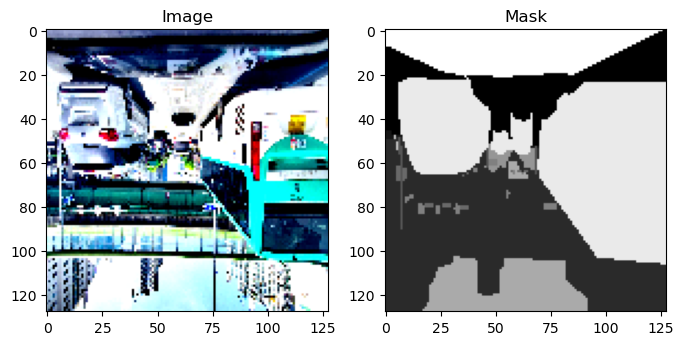

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


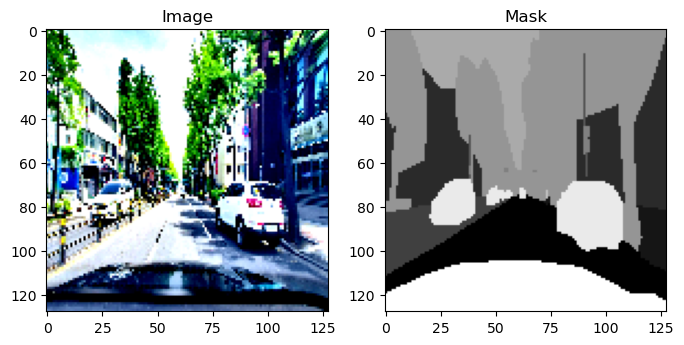

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


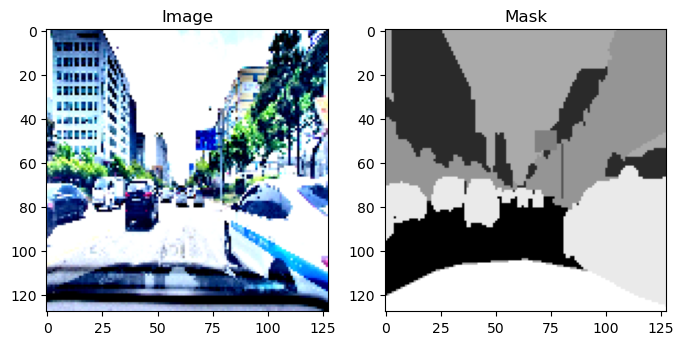

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


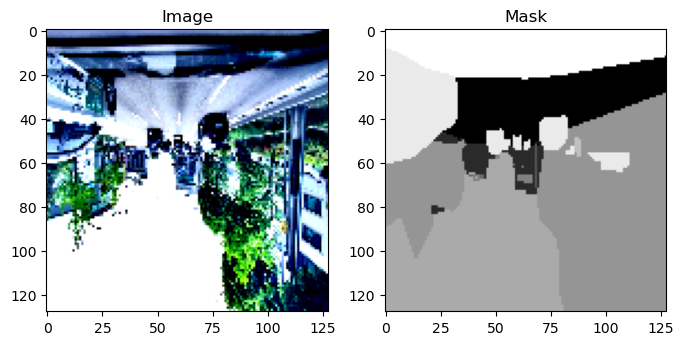

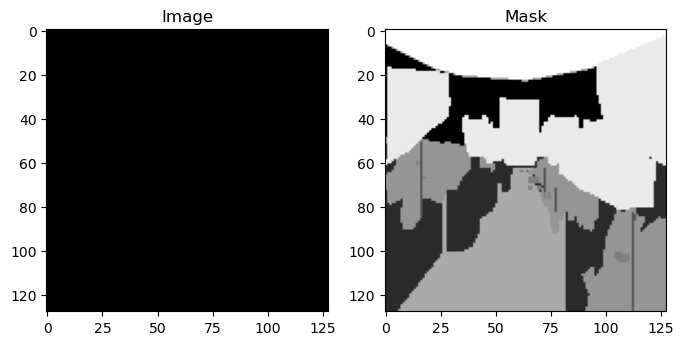

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


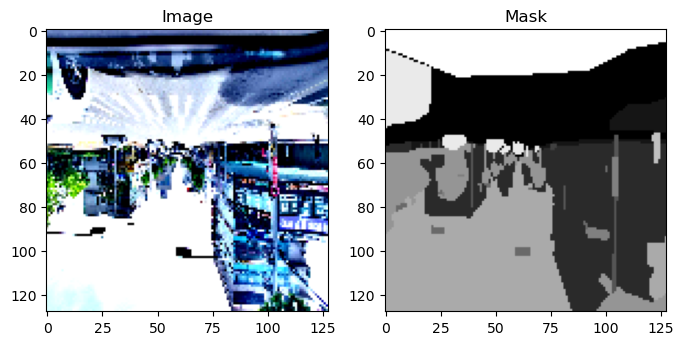

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


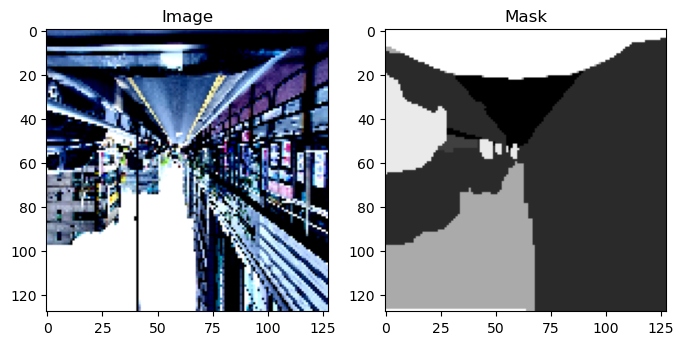

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


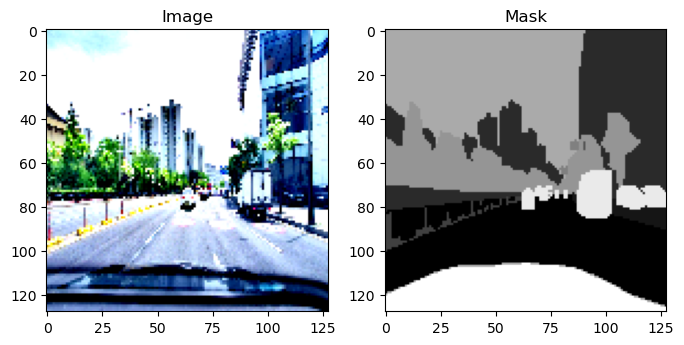

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


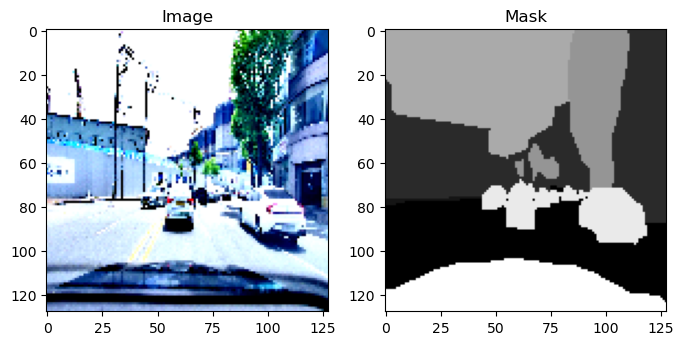

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


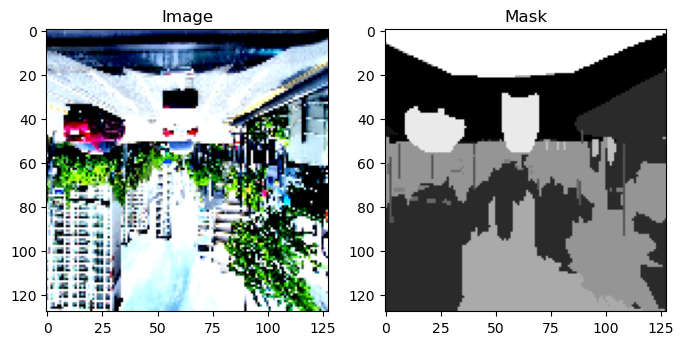

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


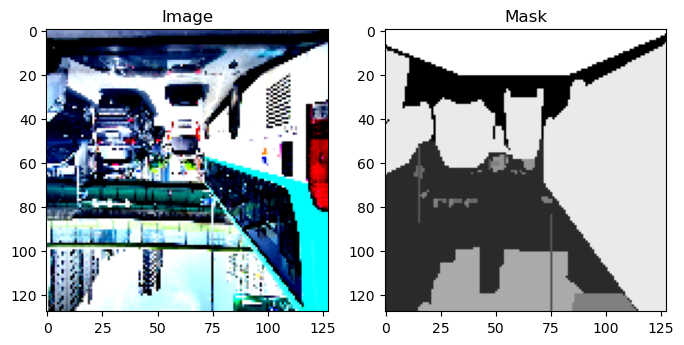

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


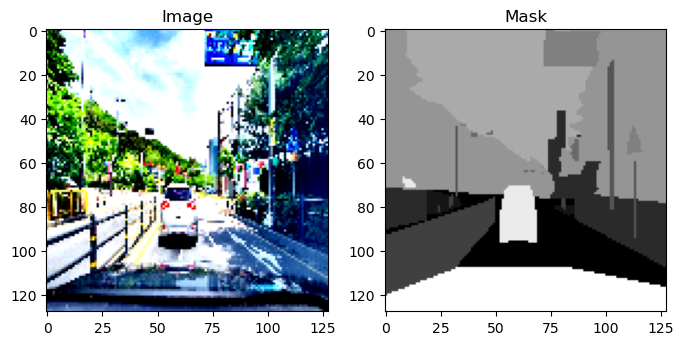

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


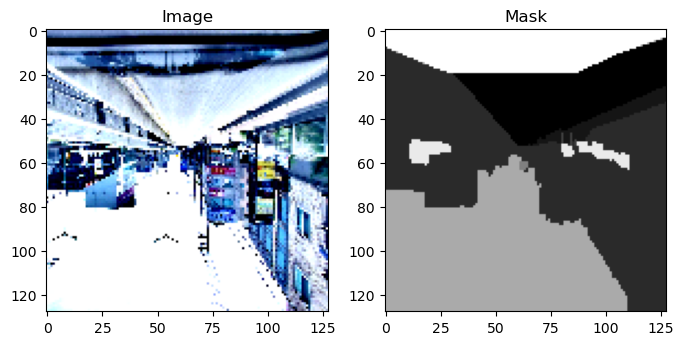

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


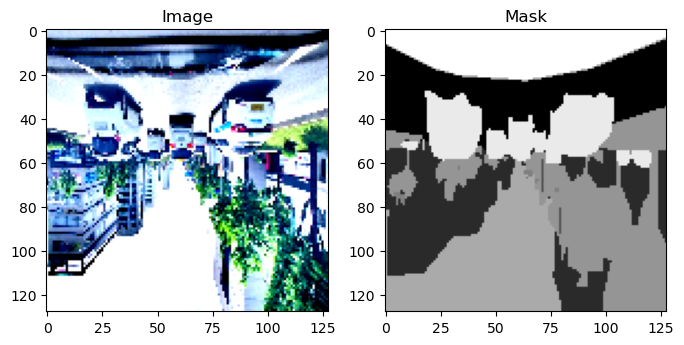

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


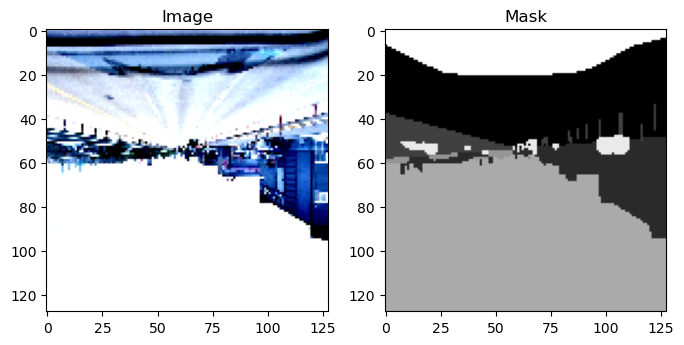

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


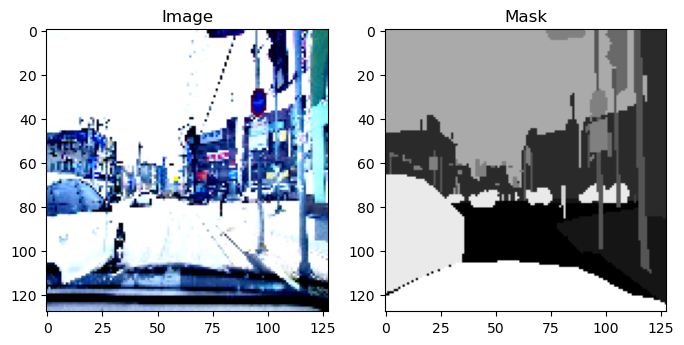

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


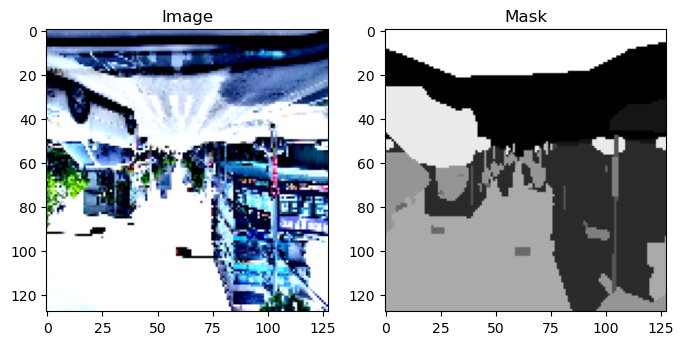

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


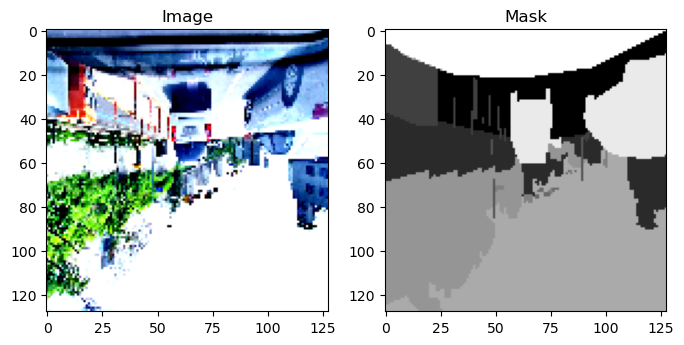

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


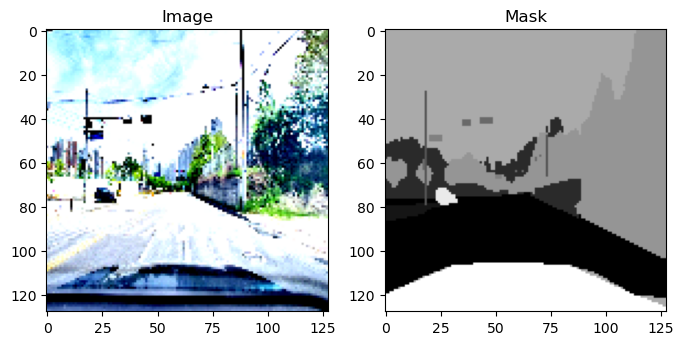

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


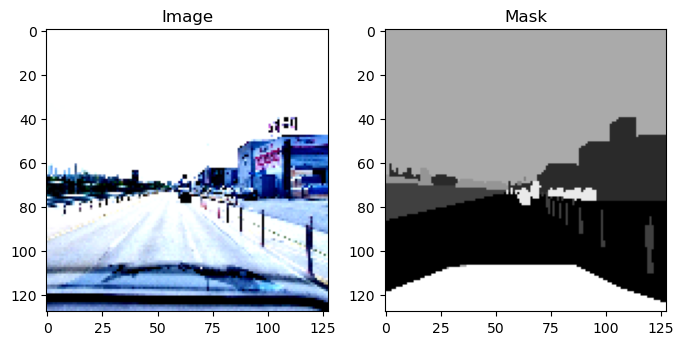

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


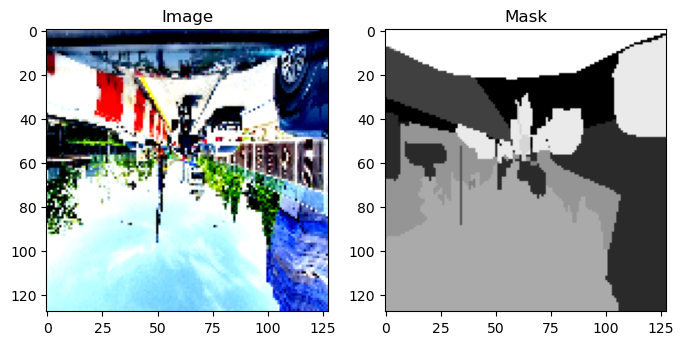

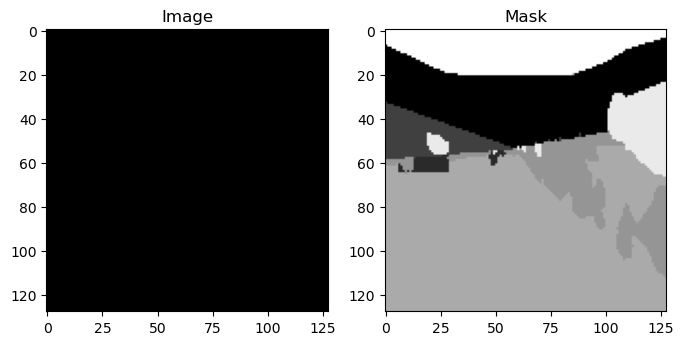

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


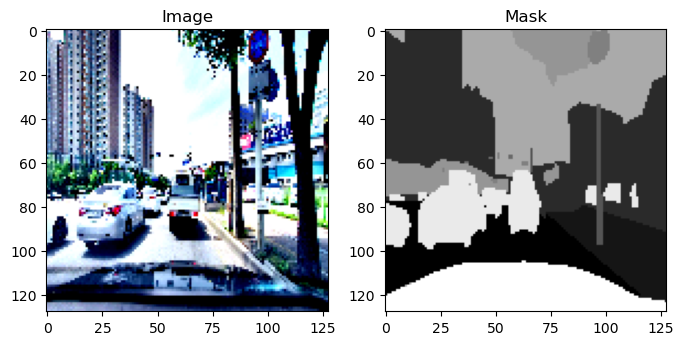

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


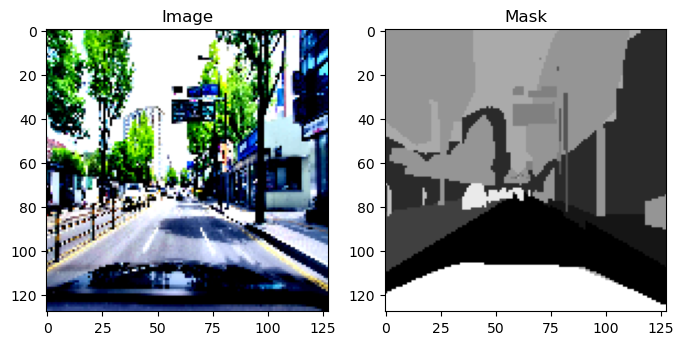

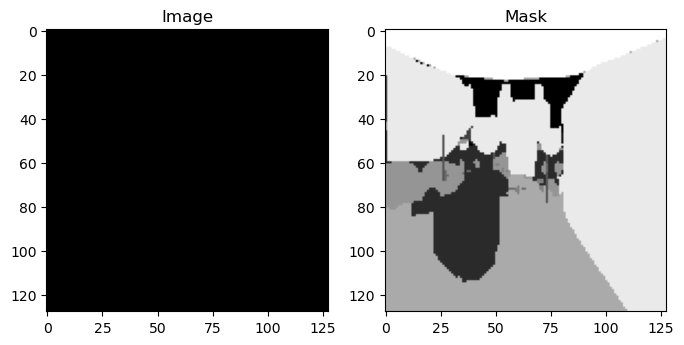

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


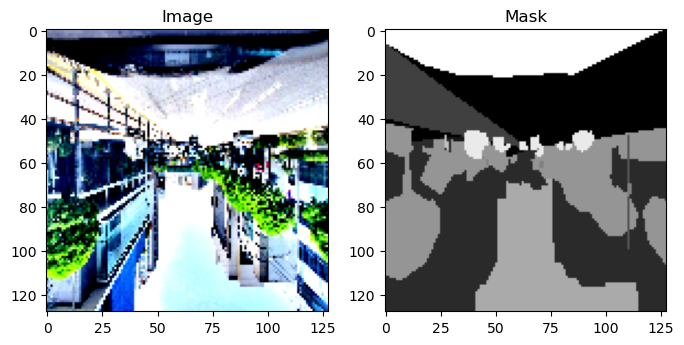

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


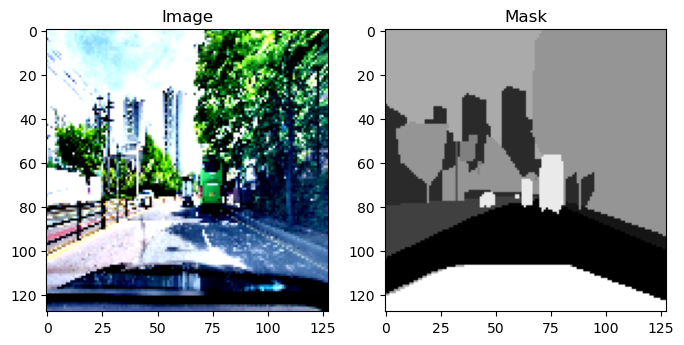

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


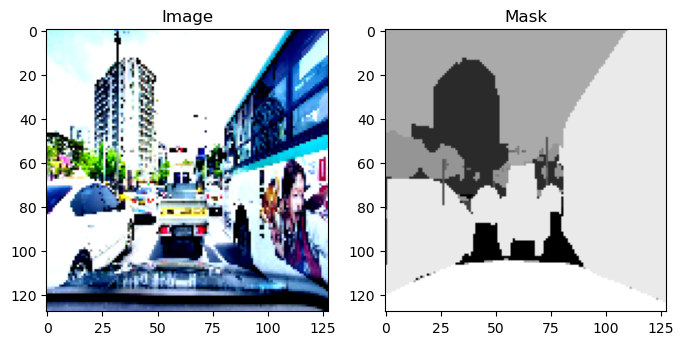

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


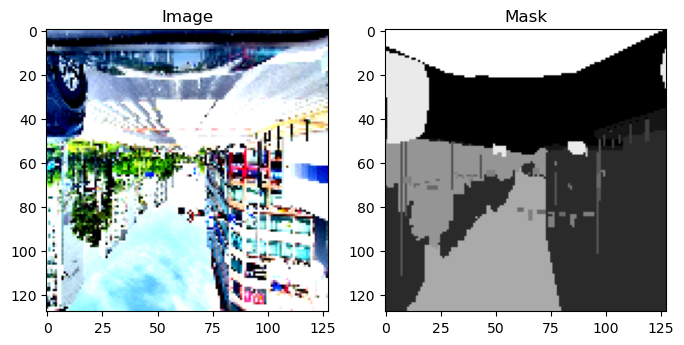

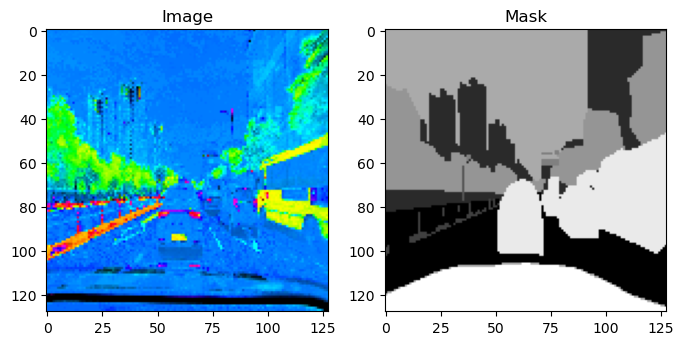

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


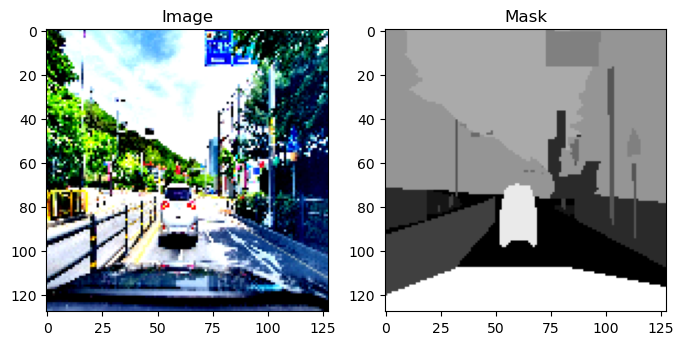

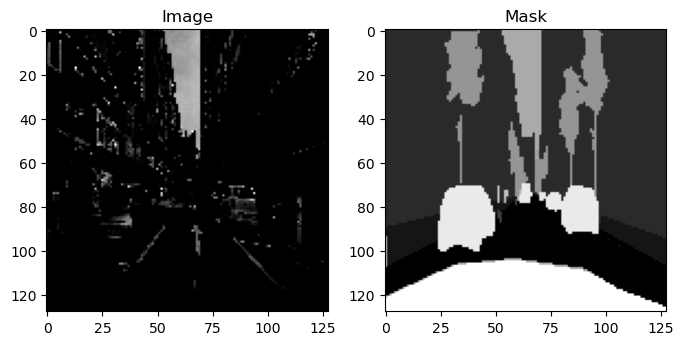

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


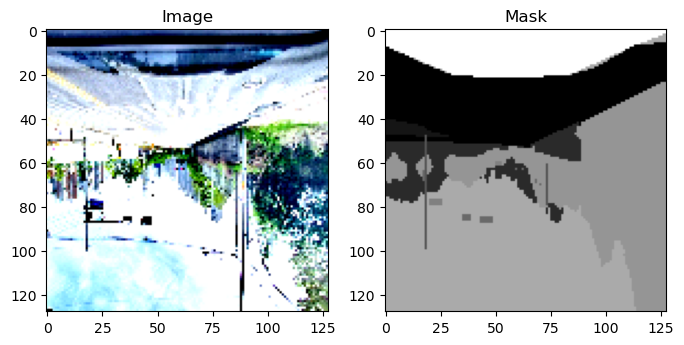

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


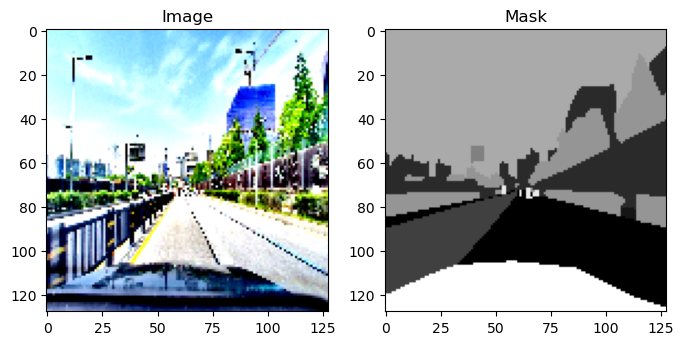

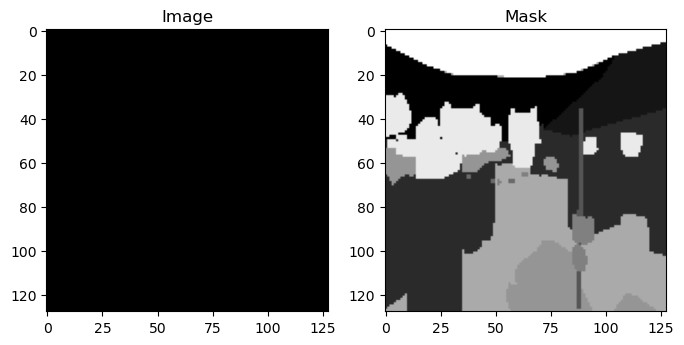

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


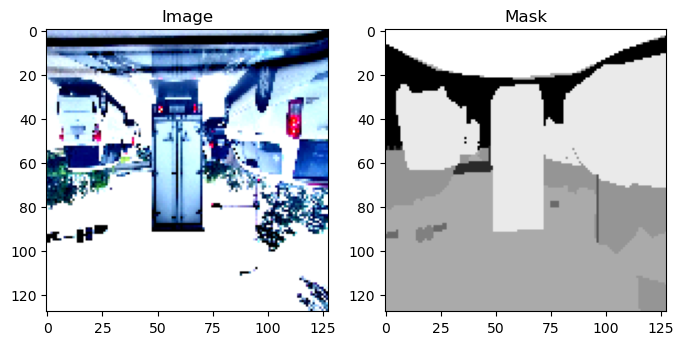

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


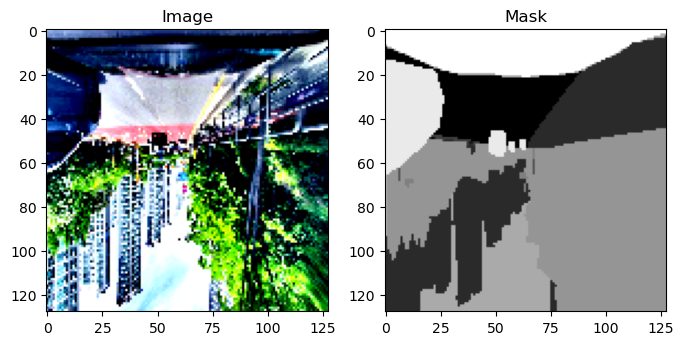

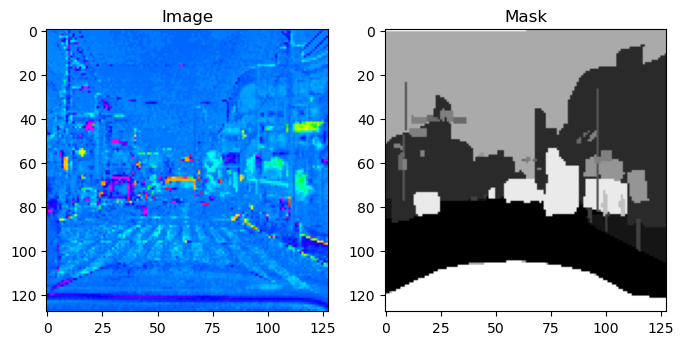

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


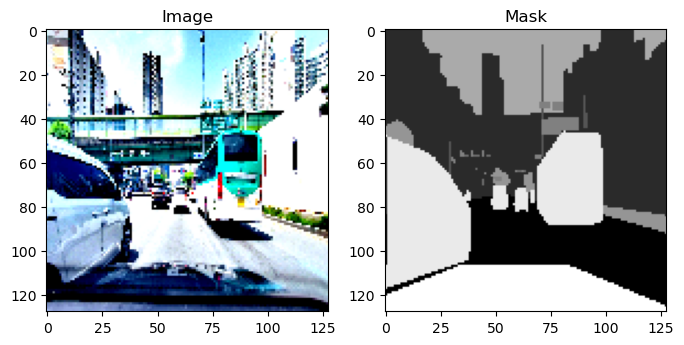

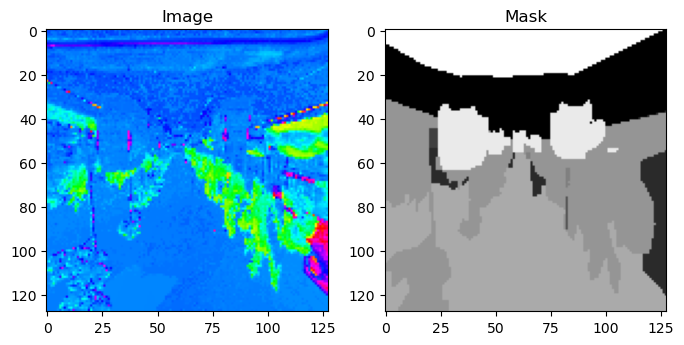

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


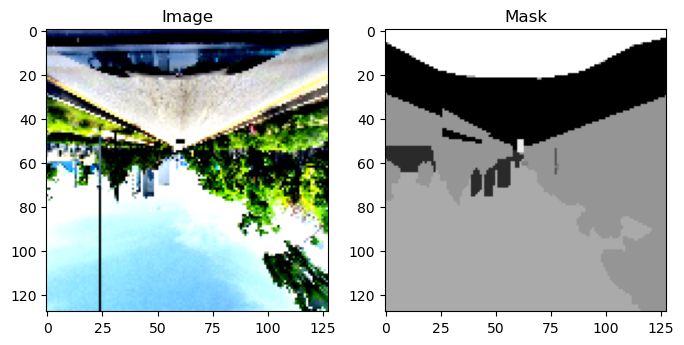

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


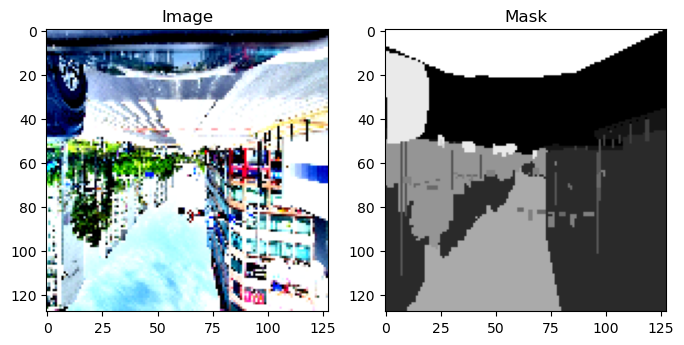

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


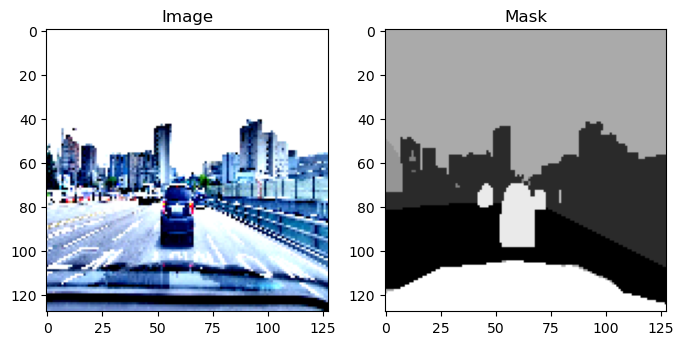

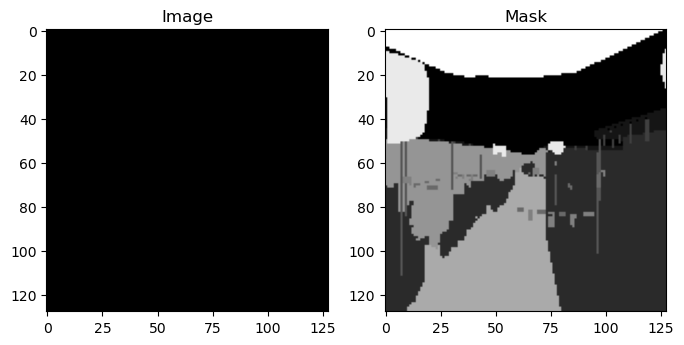

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


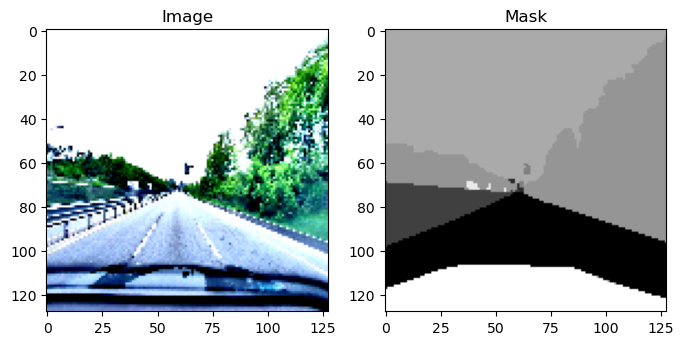

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


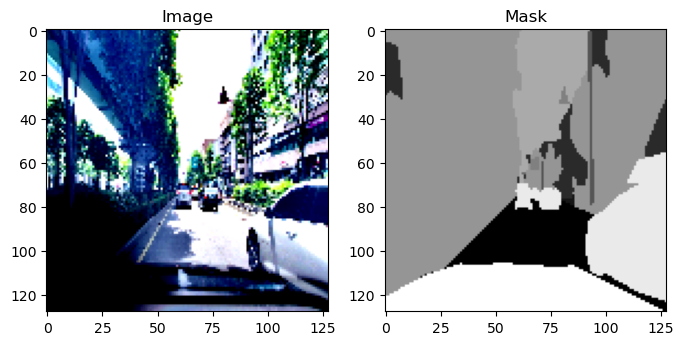

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


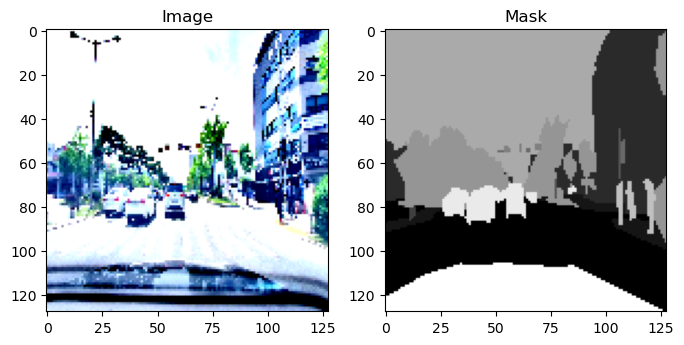

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


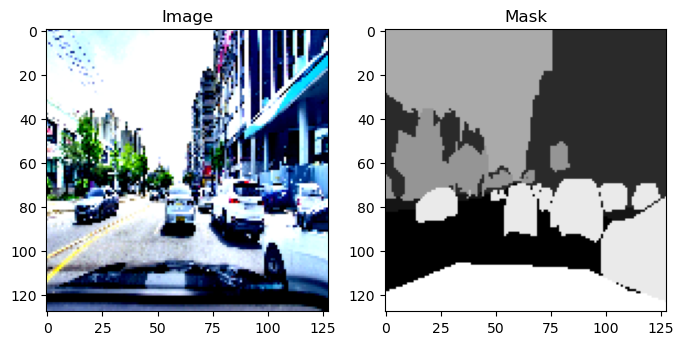

In [7]:
import matplotlib.pyplot as plt

# 데이터로더에서 배치 하나를 가져옵니다.
dataiter = iter(dataloader)
images, masks = next(dataiter)

# 이미지를 시각화합니다.
for i in range(images.size(0)):
    image = images[i].permute(1, 2, 0).numpy()  # 이미지를 CHW에서 HWC로 변환
    mask = masks[i].numpy()

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")

    plt.show()


In [8]:
# for images, masks in tqdm(dataloader):
#     a = images.float().to(device)
#     b = masks.long().to(device)
#     break

# # PyTorch Tensor를 NumPy 배열로 변환
# a_numpy = a[3].cpu().numpy()  # 첫 번째 이미지만 선택하거나 필요한 이미지를 선택하세요.
# a_numpy = np.transpose(a_numpy, (1, 2, 0))
# b_numpy = b[3].cpu().numpy()
# b_numpy = b_numpy*12

# # 이미지를 저장
# cv2.imwrite('image_source.png', a_numpy)  # 이미지 저장
# cv2.imwrite('image_mask.png', b_numpy)   # 마스크 저장

In [9]:

# for epoch in range(1):  # 5 에폭 동안 학습합니다.
          
#     # 클래스별 IoU를 누적할 리스트 초기화
#     train_class_ious = []
    
#     # 학습
#     model.train()
#     epoch_loss = 0
    
#     for images, masks in tqdm(dataloader):
#         images = images.float().to(device)
#         masks = masks.long().to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         mask_spueeze = masks.squeeze(1)
#         loss = criterion(outputs, masks.squeeze(1))
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

## Model Train

In [10]:
import random
torch.cuda.empty_cache()

for epoch in range(EP):
    # 클래스별 IoU를 누적할 리스트 초기화
    train_class_ious = []
    # 학습
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        if (epoch+1) % ACCMULATION_STEP == 0:
            optimizer.step()
            optimizer.zero_grad()
            # # Warmup 스케줄러 업데이트
            # if epoch < WUP_ITERS:
            #     scheduler_warmup.step()

        epoch_loss += loss.item()

        # train 클래스별 IoU 계산
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()

        for class_id in range(N_CLASSES):
            iou = calculate_iou_per_class(np.array(masks.cpu()), np.array(outputs), class_id)
            train_class_ious.append(iou)

    train_class_ious = np.array(train_class_ious).reshape(N_CLASSES, -1)
    train_class_ious = np.mean(train_class_ious, axis=1)
    print("--IoU Scores Train--")
    for class_id, iou in enumerate(train_class_ious):
        print(f'Class{class_id}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print()

    # mIoU 계산
    train_mIoU = np.mean(train_class_ious)

    # validation
    val_loss = 0
    val_class_ious = []  # 클래스별 IoU를 누적할 리스트 초기화
    with torch.no_grad():
        model.eval()
        for images, masks in tqdm(valid_dataloader):
            images = images.float().to(device)
            masks = masks.long().to(device)
            outputs = model(images)

            # validation loss 계산
            val_loss += criterion(outputs, masks).item()

            # validation 클래스별 IoU 계산
            outputs = torch.softmax(outputs, dim=1).cpu()
            outputs = torch.argmax(outputs, dim=1).numpy()

            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(masks.cpu()), np.array(outputs), class_id)
                val_class_ious.append(iou)

    val_class_ious = np.array(val_class_ious).reshape(N_CLASSES, -1)
    val_class_ious = np.mean(val_class_ious, axis=1)
    print("--IoU Scores Valid--")
    for class_id, iou in enumerate(val_class_ious):
        print(f'Class{class_id}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print("")

    # mIoU 계산
    val_mIoU = np.mean(val_class_ious)

    # 에폭마다 결과 출력 
    print(f"\nEpoch{epoch+1}")
    print(f"Train Loss: {(epoch_loss/len(dataloader))}, Train mIoU Score: {train_mIoU:.4f}")
    print(f"Validation Loss: {val_loss/len(valid_dataloader)}, Validation mIoU Score: {val_mIoU:.4f}")
    print("___________________________________________________________________________________________\n")


100%|██████████| 46/46 [01:30<00:00,  1.96s/it]


--IoU Scores Train--
Class0: 0.0217 Class1: 0.0243 Class2: 0.0191 Class3: 0.0243 Class4: 0.0197 Class5: 0.0230 Class6: 0.0193 
Class7: 0.0234 Class8: 0.0191 Class9: 0.0232 Class10: 0.0203 Class11: 0.0232 Class12: 0.0224 

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


--IoU Scores Valid--
Class0: 0.0175 Class1: 0.0252 Class2: 0.0278 Class3: 0.0251 Class4: 0.0063 Class5: 0.0240 Class6: 0.0285 
Class7: 0.0264 Class8: 0.0086 Class9: 0.0259 Class10: 0.0235 Class11: 0.0254 Class12: 0.0166 
Epoch1
Train Loss: 2.668857885443646, Train mIoU Score: 0.0218
Validation Loss: 2.6190055131912233, Validation mIoU Score: 0.0216
___________________________________________________________________________________________



100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


--IoU Scores Train--
Class0: 0.0221 Class1: 0.0236 Class2: 0.0192 Class3: 0.0244 Class4: 0.0201 Class5: 0.0237 Class6: 0.0200 
Class7: 0.0243 Class8: 0.0200 Class9: 0.0235 Class10: 0.0197 Class11: 0.0229 Class12: 0.0208 

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


--IoU Scores Valid--
Class0: 0.0182 Class1: 0.0261 Class2: 0.0292 Class3: 0.0293 Class4: 0.0079 Class5: 0.0273 Class6: 0.0316 
Class7: 0.0299 Class8: 0.0101 Class9: 0.0275 Class10: 0.0256 Class11: 0.0299 Class12: 0.0196 
Epoch2
Train Loss: 2.6698040547578232, Train mIoU Score: 0.0219
Validation Loss: 2.6306077241897583, Validation mIoU Score: 0.0240
___________________________________________________________________________________________



100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


--IoU Scores Train--
Class0: 0.0220 Class1: 0.0245 Class2: 0.0189 Class3: 0.0232 Class4: 0.0207 Class5: 0.0230 Class6: 0.0203 
Class7: 0.0239 Class8: 0.0197 Class9: 0.0236 Class10: 0.0196 Class11: 0.0229 Class12: 0.0226 

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


--IoU Scores Valid--
Class0: 0.0179 Class1: 0.0261 Class2: 0.0311 Class3: 0.0282 Class4: 0.0076 Class5: 0.0262 Class6: 0.0316 
Class7: 0.0297 Class8: 0.0100 Class9: 0.0271 Class10: 0.0266 Class11: 0.0295 Class12: 0.0183 
Epoch3
Train Loss: 2.668522632640341, Train mIoU Score: 0.0219
Validation Loss: 2.627350854873657, Validation mIoU Score: 0.0238
___________________________________________________________________________________________



100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


--IoU Scores Train--
Class0: 0.0210 Class1: 0.0238 Class2: 0.0191 Class3: 0.0252 Class4: 0.0196 Class5: 0.0231 Class6: 0.0190 
Class7: 0.0239 Class8: 0.0202 Class9: 0.0238 Class10: 0.0209 Class11: 0.0226 Class12: 0.0230 

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


--IoU Scores Valid--
Class0: 0.0184 Class1: 0.0257 Class2: 0.0301 Class3: 0.0294 Class4: 0.0081 Class5: 0.0267 Class6: 0.0304 
Class7: 0.0293 Class8: 0.0096 Class9: 0.0292 Class10: 0.0261 Class11: 0.0291 Class12: 0.0190 
Epoch4
Train Loss: 2.668216700139253, Train mIoU Score: 0.0219
Validation Loss: 2.6287023305892943, Validation mIoU Score: 0.0239
___________________________________________________________________________________________



100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


--IoU Scores Train--
Class0: 0.0213 Class1: 0.0241 Class2: 0.0197 Class3: 0.0241 Class4: 0.0207 Class5: 0.0247 Class6: 0.0211 
Class7: 0.0232 Class8: 0.0196 Class9: 0.0238 Class10: 0.0212 Class11: 0.0243 Class12: 0.0237 

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


--IoU Scores Valid--
Class0: 0.0185 Class1: 0.0261 Class2: 0.0312 Class3: 0.0291 Class4: 0.0078 Class5: 0.0265 Class6: 0.0314 
Class7: 0.0288 Class8: 0.0100 Class9: 0.0276 Class10: 0.0255 Class11: 0.0301 Class12: 0.0186 
Epoch5
Train Loss: 2.667475482691889, Train mIoU Score: 0.0224
Validation Loss: 2.6247955083847048, Validation mIoU Score: 0.0239
___________________________________________________________________________________________



100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


--IoU Scores Train--
Class0: 0.0217 Class1: 0.0238 Class2: 0.0192 Class3: 0.0236 Class4: 0.0202 Class5: 0.0236 Class6: 0.0199 
Class7: 0.0237 Class8: 0.0202 Class9: 0.0238 Class10: 0.0203 Class11: 0.0225 Class12: 0.0226 

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


--IoU Scores Valid--
Class0: 0.0189 Class1: 0.0254 Class2: 0.0301 Class3: 0.0296 Class4: 0.0074 Class5: 0.0260 Class6: 0.0310 
Class7: 0.0289 Class8: 0.0097 Class9: 0.0295 Class10: 0.0272 Class11: 0.0297 Class12: 0.0192 
Epoch6
Train Loss: 2.668625588002412, Train mIoU Score: 0.0219
Validation Loss: 2.6261540412902833, Validation mIoU Score: 0.0240
___________________________________________________________________________________________



  0%|          | 0/46 [00:11<?, ?it/s]


KeyboardInterrupt: 

## Inference

In [ ]:
# test_dataset = CustomDataset(csv_file='./test.csv', transform=transform, infer=True)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
# with torch.no_grad():
#     model.eval()
#     result = []
#     for images in tqdm(test_dataloader):
#         images = images.float().to(device)
#         outputs = model(images)
#         outputs = torch.softmax(outputs, dim=1).cpu()
#         outputs = torch.argmax(outputs, dim=1).numpy()
#         # batch에 존재하는 각 이미지에 대해서 반복
#         for pred in outputs:
#             pred = pred.astype(np.uint8)
#             pred = Image.fromarray(pred) # 이미지로 변환
#             pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
#             pred = np.array(pred) # 다시 수치로 변환
#             # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
#             for class_id in range(12):
#                 class_mask = (pred == class_id).astype(np.uint8)
#                 if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
#                     mask_rle = rle_encode(class_mask)
#                     result.append(mask_rle)
#                 else: # 마스크가 존재하지 않는 경우 -1
#                     result.append(-1)
        

## Submission

In [ ]:
# submit = pd.read_csv('./sample_submission.csv')
# submit['mask_rle'] = result
# submit

In [ ]:
# submit.to_csv('./baseline_submit.csv', index=False)